In [2]:
# Misc
import os 
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob 
from tqdm import tqdm
from collections import Counter as C
import Bio.PDB
import Bio.PDB.StructureBuilder
from Bio.PDB.Residue import Residue
from multiprocessing import Pool
from Bio.PDB import PDBParser
import networkx as nx
import pickle
import csv

# Torch 
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.utils import convert
from torch_geometric.data import InMemoryDataset, download_url, Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool

In [3]:
class SloppyStructureBuilder(Bio.PDB.StructureBuilder.StructureBuilder):
    """Cope with resSeq < 10,000 limitation by just incrementing internally.
    # Q: What's wrong here??
    #   Some atoms or residues will be missing in the data structure.
    #   WARNING: Residue (' ', 8954, ' ') redefined at line 74803.
    #   PDBConstructionException: Blank altlocs in duplicate residue SOL
    #   (' ', 8954, ' ') at line 74803.
    #
    # A: resSeq only goes to 9999 --> goes back to 0 (PDB format is not really
    #    good here)
    """

    # NOTE/TODO:
    # - H and W records are probably not handled yet (don't have examples
    #   to test)

    def __init__(self, verbose=False):
        Bio.PDB.StructureBuilder.StructureBuilder.__init__(self)
        self.max_resseq = -1
        self.verbose = verbose

    def init_residue(self, resname, field, resseq, icode):
        """Initiate a new Residue object.
        Arguments:
        o resname - string, e.g. "ASN"
        o field - hetero flag, "W" for waters, "H" for
            hetero residues, otherwise blanc.
        o resseq - int, sequence identifier
        o icode - string, insertion code
        """
        if field != " ":
            if field == "H":
                # The hetero field consists of
                # H_ + the residue name (e.g. H_FUC)
                field = "H_" + resname
        res_id = (field, resseq, icode)

        if resseq > self.max_resseq:
            self.max_resseq = resseq

        if field == " ":
            fudged_resseq = False
            while self.chain.has_id(res_id) or resseq == 0:
                # There already is a residue with the id (field, resseq, icode)
                # resseq == 0 catches already wrapped residue numbers which
                # do not trigger the has_id() test.
                #
                # Be sloppy and just increment...
                # (This code will not leave gaps in resids... I think)
                #
                # XXX: shouldn't we also do this for hetero atoms and water??
                self.max_resseq += 1
                resseq = self.max_resseq
                res_id = (field, resseq, icode)  # use max_resseq!
                fudged_resseq = True

            if fudged_resseq and self.verbose:
                sys.stderr.write(
                    "Residues are wrapping (Residue "
                    + "('%s', %i, '%s') at line %i)."
                    % (field, resseq, icode, self.line_counter)
                    + ".... assigning new resid %d.\n" % self.max_resseq
                )
        residue = Residue(res_id, resname, self.segid)
        self.chain.add(residue)
        self.residue = residue

class SloppyPDBIO(Bio.PDB.PDBIO):
    """PDBIO class that can deal with large pdb files as used in MD simulations
    - resSeq simply wrap and are printed modulo 10,000.
    - atom numbers wrap at 99,999 and are printed modulo 100,000
    """

    # The format string is derived from the PDB format as used in PDBIO.py
    # (has to be copied to the class because of the package layout it is not
    # externally accessible)
    _ATOM_FORMAT_STRING = (
        "%s%5i %-4s%c%3s %c%4i%c   " + "%8.3f%8.3f%8.3f%6.2f%6.2f      %4s%2s%2s\n"
    )

    def _get_atom_line(
        self,
        atom,
        hetfield,
        segid,
        atom_number,
        resname,
        resseq,
        icode,
        chain_id,
        element="  ",
        charge="  ",
    ):
        """Returns an ATOM string that is guaranteed to fit the ATOM format.
        - Resid (resseq) is wrapped (modulo 10,000) to fit into %4i (4I) format
        - Atom number (atom_number) is wrapped (modulo 100,000) to fit into
          %5i (5I) format
        """
        if hetfield != " ":
            record_type = "HETATM"
        else:
            record_type = "ATOM  "
        name = atom.get_fullname()
        altloc = atom.get_altloc()
        x, y, z = atom.get_coord()
        bfactor = atom.get_bfactor()
        occupancy = atom.get_occupancy()
        args = (
            record_type,
            atom_number % 100000,
            name,
            altloc,
            resname,
            chain_id,
            resseq % 10000,
            icode,
            x,
            y,
            z,
            occupancy,
            bfactor,
            segid,
            element,
            charge,
        )
        return self._ATOM_FORMAT_STRING % args
        
def generate_graphs(adjacency_matrix, show=False, self_loops=False):
        """Generates the initial graphs from provided adjacency matrices.
        :param adjacency_matrix_1: proximity matrix for protein 1
        :type adjacency_matrix_1: np.array
        :param adjacency_matrix_2: proximity matrix for protein 2
        :type adjacency_matrix_2: np.array
        :param show: plot graphs, defaults to False
        :type show: bool, optional
        :return: returns networkX graphs corrresponding to each adjacency matrix
        :rtype: tuple of networkX objects
        """
        # Generate graphs
        G = nx.from_numpy_matrix(adjacency_matrix)
        
        if self_loops == False:
            # Remove self loops on residues
            G.remove_edges_from(nx.selfloop_edges(G))


        if show:
            # Plot the graphs
            plt.subplots(figsize=(12, 8))
            pos = nx.spring_layout(G)
            nx.draw(G, with_labels=False, edge_color="black",
                    node_size=10, width=0.2)
            plt.show()

        return G

def get_structure(pdbfile, pdbid="system"):

    # convenience functions
    sloppyparser = Bio.PDB.PDBParser(
        PERMISSIVE=True, structure_builder=SloppyStructureBuilder()
    )

    return sloppyparser.get_structure(pdbid, pdbfile)

def generate_alpha_fold_structures(string_to_af, pair_1):
        """Queries alpha-fold predictions for a given protein sequnece and returns
         alpha-fold predicted structures.

        :param string_to_af: mapping path between string-alphaFold
        :type string_to_af: string
        :param pair_1: protein name 1
        :type pair_1: string
        :param pair_2: protein name 2
        :type pair_2: string
        :return: alphaFold structures for each protein
        :rtype: objects
        """

        # Map from STRING to Alpha-Fold
        ecoli_maps = pd.read_csv(
            string_to_af, sep='\t', engine='python', header=None)
        map_1 = ecoli_maps[ecoli_maps[0] == pair_1]

        # Save and import map files
        test_file_1 = map_1.iloc[0, -1]
        test_file_1 = test_file_1.replace('.gz', '')
    

        # Create sloppy parser
        sloppy_parser = PDBParser(structure_builder=SloppyStructureBuilder())
        protein_1 = sloppy_parser.get_structure(id=None, file=test_file_1)

        # Structure 1
        sloppyio_1 = SloppyPDBIO()
        sloppyio_1.set_structure(protein_1)

        # Get protein residue structures
        residues_1 = [x for x in sloppyio_1.structure.get_residues()]
        return residues_1

def calculate_residue_dist(seq_1, seq_2):
    """Calculates the euclidean distance between two residues in 3D space.
    :param residue_one: reference residue
    :type residue_one:  object
    :param residue_two: target residue
    :type residue_two: object
    :return: sqaured euclidean distance
    :rtype: float
    """
    diff_vector = seq_1["CA"].coord - seq_2["CA"].coord
    sq_dist = np.sqrt(np.sum(diff_vector * diff_vector))
    return sq_dist

def calculate_dist_matrix(seq_1, seq_2):
        """Calculates the distance matrix for all pairwise residues
        :param seq_1: protein sequence 1
        :type seq_1: string
        :param seq_2: protein sequence 2
        :type seq_2: string
        :return: an nd array which encodes pairwise residue distances
        :rtype: np.array
        """
        d_mat = np.zeros((len(seq_1), len(seq_2)), float)
        for row, residue_one in enumerate(seq_1):
            for col, residue_two in enumerate(seq_2):
                euclidean_dist = calculate_residue_dist(
                    residue_one, residue_two)
                d_mat[row, col] = euclidean_dist
        return d_mat

def generate_proximity_matrix(seq_1, seq_2, angstroms=10, show=False):
        """Creates an adacency matrix for points within n angstroms of each other
        :param seq_1: protein sequence 1
        :type seq_1: string
        :param seq_2: protein sequence 2
        :type seq_2: sting
        :param angstroms: max distance threshold , defaults to 10
        :type angstroms: int, optional
        :param show: to plot matrix, defaults to False
        :type show: bool, optional
        :return: a proximity matrix for points considered less than n angstroms apart
        :rtype: np.array
        """

        # Select the residues from maps that are less than 'n' angstoms apart
        contact_map = calculate_dist_matrix(seq_1, seq_2)
        adjacency_matrix = np.zeros(np.shape(contact_map))
        adjacency_matrix[contact_map < angstroms] = 1

        if show:
            plt.subplots(figsize=(12, 12))
            sns.heatmap(adjacency_matrix)
            plt.show()
        return adjacency_matrix
        
def populate_graph_features(graph, x_net_surf):
        """ Populates each node (residue) with its respective net-surf feature vector
        :param graph_1: graph for protein 1
        :type graph_1: networkX graph object
        
        :param x_net_surf_1: net-surf feautures for protein 1
        :type x_net_surf_1: pandas dataframe

        :return: a graph populated with node features
        :rtype: tuple of networkX graphs
        """

        # Protein netsurfp
        vars_to_keep = [x for x in x_net_surf.columns if x not in [
            'id', 'seq', 'n', 'q3', 'q8']]        
        features = x_net_surf.loc[:, vars_to_keep]

        # Populate node features 
        G_features = {}
        for i, node in enumerate(graph.nodes):
            feature_array = {'x': features.iloc[i, :].values}
            G_features[node] = feature_array

        # Set the node attributes
        nx.set_node_attributes(graph, G_features)
        return graph

def get_node_features(graph, node_number):
    # Get a nodes features
    return nx.get_node_attributes(G, 'x')[node_number]

def read_fasta(path):
    # Read in the file
    with open(sequences[0]) as f:
        lines = f.readlines()
    # Format the string as list
    for line in lines:
        x = list(line.strip())
    return x
    
def format_graphs(graphs, label=1):
    graph_list = []
    # Convert into pytorch geoetric dataset: Positive
    for i, x in enumerate(tqdm(graphs)):
        F = nx.convert_node_labels_to_integers(x)
        for (n1, n2, d) in F.edges(data=True):
            d.clear()
        data = convert.from_networkx(F, group_edge_attrs=None)
        data.y = torch.FloatTensor([label])
        graph_list.append(data)
    return graph_list

In [4]:
# Annotation file
anndata_path = ('/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/'
                '511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINPhyPPI_Benchmark/allPPI_allInfo_frame.csv')

# Netsurf data
netsurf_path = ("/mnt/mnemo6/tao/PPI_Coevolution/STRING_data_11.5/511145_netsurfp2_output/")

# Specify sequence data
sequence_path = ("/mnt/mnemo6/tao/PPI_Coevolution/STRING_data_11.5/511145ByProteins/")

# ALPHA-Fold paths
string_to_af = "/mnt/mnemo6/damian/STRING_derived_v11.5/alphafold/mapping/83333.511145.tsv"
string_to_pdb = '/mnt/mnemo6/damian/STRING_derived_v11.5/pdb/pdb2string.blastp.best_score.tsv'
pdb_files_for_PDB = '/mnt/mnemo6/damian/STRING_freeze_v11.5/pdb/data/biounit/coordinates/divided/'


In [5]:
# Netsurf outputs
netsurf = glob.glob(os.path.join(netsurf_path, "*.csv"))
sequences = glob.glob(os.path.join(sequence_path, "*.csv"))

# Sort the files
netsurf.sort()
sequences.sort()

# Generate map between protein names and netsurfp file paths
seq_names = [x.split("/")[-1].replace(".csv", "") for x in netsurf]
netsurf_d = dict(zip(seq_names, netsurf))

# Load anndata object
anndata = pd.read_csv(anndata_path, sep='\t')


In [6]:

# Itstantiate graph collections
graphs_1 = []
graphs_2 = []
graph_labels = []
SAVE = False

# Generate all graphs
rows, cols = np.shape(anndata)
for i in tqdm(range(rows)):

    try:
        # Grab protein names
        protein_1, protein_2 = anndata.loc[i, ['STRING_ID1', 'STRING_ID2']]
        di_graph_name = "and".join([protein_1, protein_2])

        # Pull out path for each protein
        p1_path, p2_path = netsurf_d[protein_1], netsurf_d[protein_2]
        

        # Get raw protein data
        p1_x, p2_x = pd.read_csv(p1_path), pd.read_csv(p2_path)
        seq_1, seq_2 = "".join(p1_x['seq'].values), "".join(p2_x['seq'].values)

        # Get interaction label
        interact_meta = anndata[(anndata['STRING_ID1'] == protein_1) & (anndata['STRING_ID2'] == protein_2)]
        interact_stataus = interact_meta['benchmark_status'].values
        interact_label = 1 if interact_stataus == 'P' else 0
        # graph_labels.append(interact_label)
        
        # Extract alpha-fold structure based on protein names
        residues_1 = generate_alpha_fold_structures(string_to_af, protein_1)
        residues_2 = generate_alpha_fold_structures(string_to_af, protein_2)

        # Generate proximity matrices
        prox_1 = generate_proximity_matrix(
            residues_1, residues_1, angstroms=10, show=False)
        prox_2 = generate_proximity_matrix(
            residues_2, residues_2, angstroms=10, show=False)

        # Remove self-loops from graphs
        G_1 = generate_graphs(prox_1, show=False, self_loops=False)
        G_2 = generate_graphs(prox_2, show=False, self_loops=False)

        # Populate each node with netsurfp features
        G_1 = populate_graph_features(G_1, x_net_surf=p1_x)
        G_2 = populate_graph_features(G_2, x_net_surf=p2_x)

        # Append graphs
        graphs_1.append(G_1)
        graphs_2.append(G_2)
        break

        if SAVE:
            ######## Save the graphs ########
            folder_1 = "di_graphs_1"
            folder_2 = "di_graphs_2"
            labels_folder_name = 'di_graph_labels'
            
            # Check directories exist - graphs_1
            if not(os.path.isdir(folder_1)):
                print("Created {} directory.".format(folder_1))
                os.mkdir(folder_1)
                
            # Check directories exist - graphs_2
            if not(os.path.isdir(folder_2)):
                print("Created {} directory.".format(folder_2))
                os.mkdir(folder_2)

            # Check directories exist - labels
            if not(os.path.isdir(labels_folder_name)):
                print("Created {} directory.".format(labels_folder_name))
                os.mkdir(labels_folder_name)


            # Save graph to respective directory
            nx.write_gpickle(G_1, os.path.join(
                        folder_1, str(i) + '_' + protein_1 + ".gpickle"))

            nx.write_gpickle(G_2, os.path.join(
                        folder_2, str(i) + '_' + protein_2 + ".gpickle"))

            # Format data to save on the fly (labels)
            labels_fn = os.path.join(labels_folder_name, 'labels.csv')
            fieldnames = ['protein_1', 'protein_2', 'label']
            row = {
                'protein_1':  protein_1,
                'protein_2': protein_2, 
                'label': int(interact_label)}

            # Open the file to append data to - only save new entries
            with open(labels_fn, 'a') as fd:
                writer = csv.DictWriter(fd, fieldnames=fieldnames)

                # Open file using seperate reader, and check the rows
                with open(labels_fn, 'r') as file1:
                    existing_lines = [
                        line for line in csv.reader(file1, delimiter=',')]
                    row_check = [x for x in row.values()]

                    # If header already present, don't write
                    if fieldnames not in existing_lines:
                        writer.writeheader()

                    # If row already present, don't write
                    if row_check not in existing_lines:
                        writer.writerow(row)
    except:
        print('Skipping example: {}and{}'.format(protein_1, protein_2))
        continue

    

  0%|          | 0/18492 [00:00<?, ?it/s]


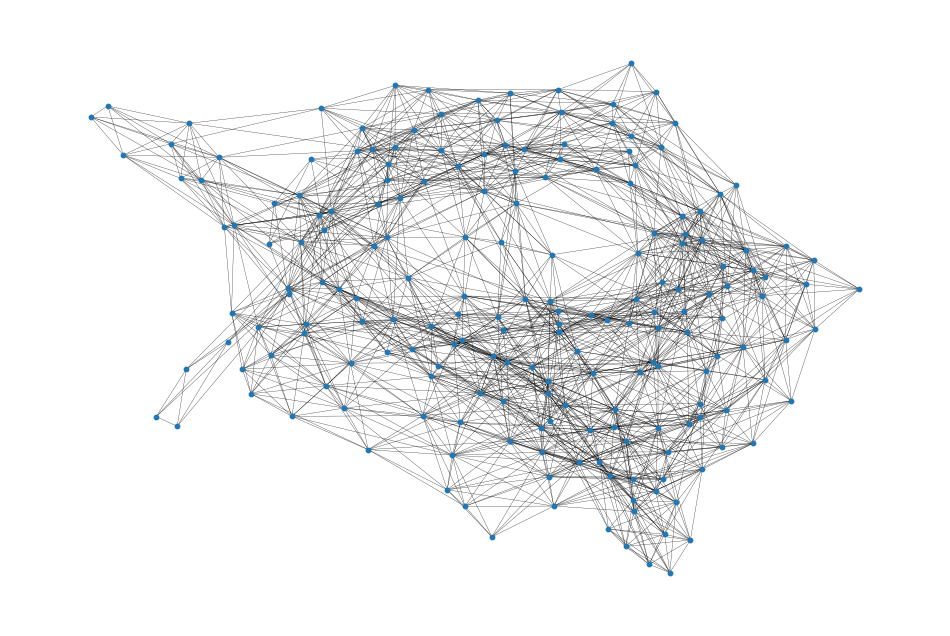

<ipython-input-8-bb36f2cd4abb>:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G_1).todense()


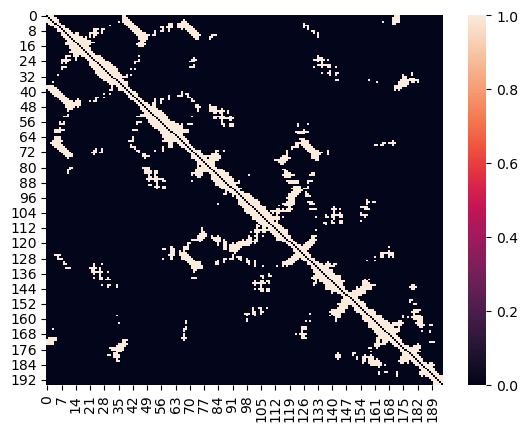

In [8]:
 G_1 = generate_graphs(prox_1, show=True, self_loops=False)
 A = nx.adjacency_matrix(G_1).todense()
 sns.heatmap(A)
 plt.show()

In [19]:
BATCH_SIZE = 2
graph_1_loader = DataLoader(gl_1, batch_size=BATCH_SIZE, shuffle=True)
graph_3_loader = DataLoader(gl_2, batch_size=BATCH_SIZE, shuffle=True)